## Fairness Analysis of NamSor's Ethnicity API Endpoint using Aequitas

Part I: Fairness of Ethnicity Endpoint by Ethnicity and Gender

In [1]:
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

# import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv("data/compas_ethnicity_predictions.csv")
df.head()

,Unnamed: 0,entity_id,first,last,race,race_pred,sex,score,label_value
0,0,1,miguel,hernandez,Other,Hispanic,Male,0.024501,0.0
1,1,3,kevon,dixon,African-American,African-American,Male,0.142035,1.0
2,2,4,ed,philo,African-American,Asian,Male,0.388947,0.0
3,3,5,marcu,brown,African-American,African-American,Male,0.235928,1.0
4,4,6,bouthy,pierrelouis,Other,African-American,Male,0.199168,0.0


In [3]:
# Non String columns will lead to problems later so we have to find out if there are any
non_attr_cols = ['id', 'model_id', 'entity_id', 'score', 'label_value', 'rank_abs', 'rank_pct']
attr_cols = df.columns[~df.columns.isin(non_attr_cols)]  # index of the columns that are
df.columns[(df.dtypes != object) & (df.dtypes != str) & (df.columns.isin(attr_cols))]

Index(['Unnamed: 0'], dtype='object')

In [4]:
# And delete them.
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,entity_id,first,last,race,race_pred,sex,score,label_value
0,1,miguel,hernandez,Other,Hispanic,Male,0.024501,0.0
1,3,kevon,dixon,African-American,African-American,Male,0.142035,1.0
2,4,ed,philo,African-American,Asian,Male,0.388947,0.0
3,5,marcu,brown,African-American,African-American,Male,0.235928,1.0
4,6,bouthy,pierrelouis,Other,African-American,Male,0.199168,0.0


In [5]:
# we only want to look at ethnicity here, since that is what we calculated label_value for
df = df.drop(['race_pred', 'first', 'last'], axis=1) # if we don't drop the tables, Aequitas thinks these are attributes by which groups should be separated

In [6]:
df.shape

(7214, 5)

## Group Metrics

In [7]:
t = 0.2

In [8]:
g = Group()
xtab, _ = g.get_crosstabs(df, attr_cols=["race", "sex"], score_thresholds= {'score': [t]})
absolute_metrics = g.list_absolute_metrics(xtab)

model_id, score_thresholds 0 {'score': [0.2]}


In [9]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,0.2_ore,2790,race,African-American,1150,2546,130,1770,776,1020,2790,906,3696,7214
1,0,0.2_ore,2790,race,Asian,22,10,1,5,5,21,26,6,32,7214
2,0,0.2_ore,2790,race,Caucasian,979,1475,529,987,488,450,1437,1017,2454,7214
3,0,0.2_ore,2790,race,Hispanic,522,115,2,71,44,520,591,46,637,7214
4,0,0.2_ore,2790,race,Native American,4,14,4,0,14,0,0,18,18,7214
5,0,0.2_ore,2790,race,Other,113,264,113,0,264,0,0,377,377,7214
6,0,0.2_ore,2790,sex,Female,528,867,139,546,321,389,935,460,1395,7214
7,0,0.2_ore,2790,sex,Male,2262,3557,640,2287,1270,1622,3909,1910,5819,7214


In [10]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,African-American,0.37,0.86,0.70,0.11,0.14,0.63,0.30,0.89,0.41,0.31,0.75
1,race,Asian,0.81,0.83,0.50,0.05,0.17,0.19,0.50,0.95,0.01,0.69,0.81
2,race,Caucasian,0.31,0.48,0.67,0.54,0.52,0.69,0.33,0.46,0.35,0.40,0.59
3,race,Hispanic,0.88,0.96,0.62,0.00,0.04,0.12,0.38,1.00,0.19,0.82,0.93
4,race,Native American,NaN,0.78,0.00,1.00,0.22,NaN,1.00,0.00,0.00,0.22,0.00
5,race,Other,NaN,0.70,0.00,1.00,0.30,NaN,1.00,0.00,0.04,0.30,0.00
6,sex,Female,0.42,0.70,0.63,0.26,0.30,0.58,0.37,0.74,0.19,0.38,0.67
7,sex,Male,0.41,0.66,0.64,0.28,0.34,0.59,0.36,0.72,0.81,0.39,0.67


### Visualize Group Metrics

In [11]:
aq_palette = sns.diverging_palette(225, 35, n=2)
aqp = Plot()

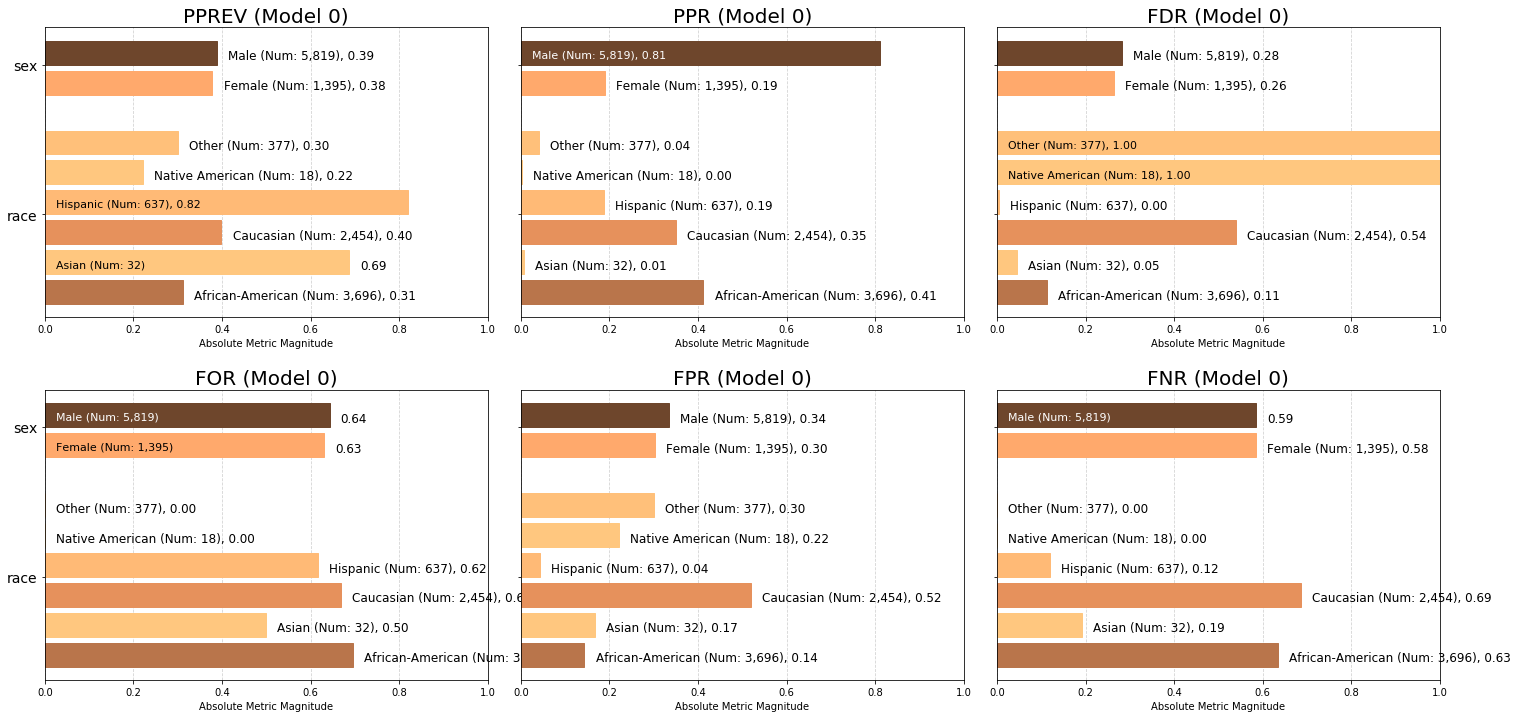

<Figure size 432x288 with 0 Axes>

In [12]:
a = aqp.plot_group_metric_all(xtab, ncols=3)

## Disparities of Group Metrics

In [13]:
b = Bias()
df.head()

,entity_id,race,sex,score,label_value
0,1,Other,Male,0.024501,0.0
1,3,African-American,Male,0.142035,1.0
2,4,African-American,Male,0.388947,0.0
3,5,African-American,Male,0.235928,1.0
4,6,Other,Male,0.199168,0.0


In [14]:
df.dtypes

entity_id        int64
race            object
sex             object
score          float64
label_value    float64
dtype: object

#### Disparities calculated in relation to a user-specified group for each attribute

In [15]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, 
                                        ref_groups_dict={'race':'Caucasian', 'sex':'Male'}, 
                                        alpha=0.05, check_significance=False, # try with check_significance=True
                                        mask_significance=False)
bdf.style

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,0.2_ore,2790,race,African-American,0.365591,0.856512,0.695208,0.113043,0.143488,0.634409,0.304792,0.886957,1150,2546,0.412186,0.311147,130,1770,776,1020,2790,906,3696,7214,0.75487,1.17467,0.779934,1.92962,0.209205,1.03894,0.275855,0.923653,1.16746,1.78499,0.921246,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
1,0,0.2_ore,2790,race,Asian,0.807692,0.833333,0.5,0.0454545,0.166667,0.192308,0.5,0.954545,22,10,0.0078853,0.6875,1,5,5,21,26,6,32,7214,0.8125,0.0224719,1.72331,2.07667,0.084121,0.747214,0.320416,0.279986,2.57923,1.73668,1.51127,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
2,0,0.2_ore,2790,race,Caucasian,0.313152,0.479843,0.669153,0.540347,0.520157,0.686848,0.330847,0.459653,979,1475,0.350896,0.398941,529,987,488,450,1437,1017,2454,7214,0.585575,1,1,1,1,1,1,1,1,1,1,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
3,0,0.2_ore,2790,race,Hispanic,0.879865,0.956522,0.617391,0.00383142,0.0434783,0.120135,0.382609,0.996169,522,115,0.187097,0.819466,2,71,44,520,591,46,637,7214,0.927786,0.533197,2.05411,2.16722,0.00709066,0.922647,0.0835868,0.174908,2.8097,1.99341,1.15645,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
4,0,0.2_ore,2790,race,Native American,nan,0.777778,0,1,0.222222,nan,1,0,4,14,0.00143369,0.222222,4,0,14,0,0,18,18,7214,0,0.0040858,0.557031,0,1.85066,0,0.427221,nan,nan,1.6209,3.02254,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
5,0,0.2_ore,2790,race,Other,nan,0.700265,0,1,0.299735,nan,1,0,113,264,0.0405018,0.299735,113,0,264,0,0,377,377,7214,0,0.115424,0.751327,0,1.85066,0,0.576239,nan,nan,1.45936,3.02254,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
6,0,0.2_ore,2790,sex,Female,0.416043,0.697826,0.629758,0.263258,0.302174,0.583957,0.370242,0.736742,528,867,0.189247,0.378495,139,546,321,389,935,460,1395,7214,0.670251,0.233422,0.973678,1.02744,0.930451,0.97947,0.9018,0.998115,1.00266,1.04949,1.03697,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
7,0,0.2_ore,2790,sex,Male,0.41494,0.664921,0.642958,0.282935,0.335079,0.58506,0.357042,0.717065,2262,3557,0.810753,0.388727,640,2287,1270,1622,3909,1910,5819,7214,0.671765,1,1,1,1,1,1,1,1,1,1,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male


In [16]:
# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +
     b.list_disparities(bdf) + b.list_significance(bdf)].style

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,race,African-American,1.17467,0.779934,1.92962,0.209205,1.03894,0.275855,0.923653,1.16746,1.78499,0.921246
1,race,Asian,0.0224719,1.72331,2.07667,0.084121,0.747214,0.320416,0.279986,2.57923,1.73668,1.51127
2,race,Caucasian,1,1,1,1,1,1,1,1,1,1
3,race,Hispanic,0.533197,2.05411,2.16722,0.00709066,0.922647,0.0835868,0.174908,2.8097,1.99341,1.15645
4,race,Native American,0.0040858,0.557031,0,1.85066,0,0.427221,nan,nan,1.6209,3.02254
5,race,Other,0.115424,0.751327,0,1.85066,0,0.576239,nan,nan,1.45936,3.02254
6,sex,Female,0.233422,0.973678,1.02744,0.930451,0.97947,0.9018,0.998115,1.00266,1.04949,1.03697
7,sex,Male,1,1,1,1,1,1,1,1,1,1


### Visualizing disparities

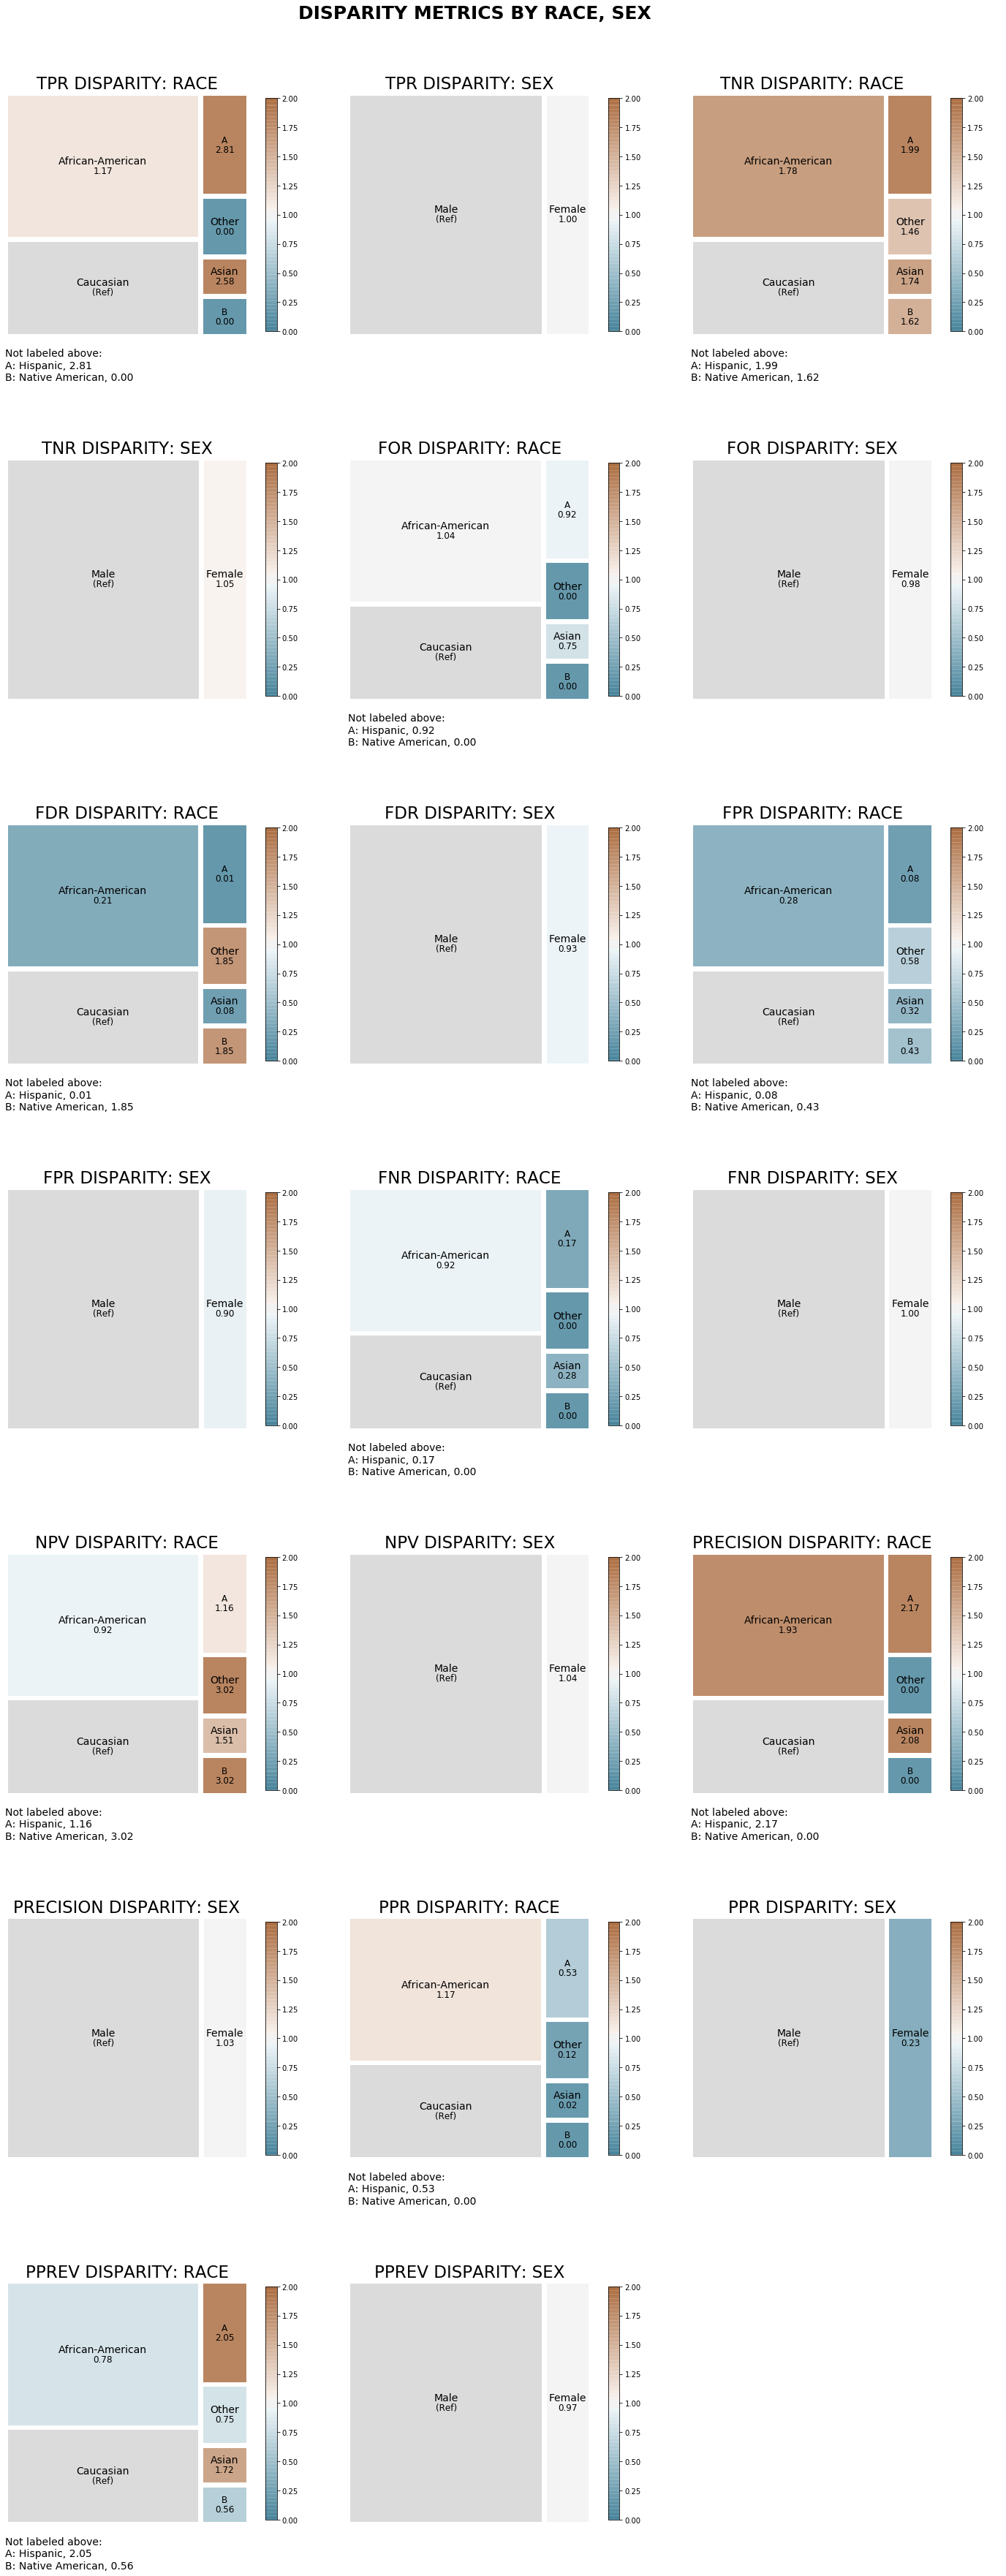

In [17]:
tm_capped = aqp.plot_disparity_all(bdf, attributes=['race', 'sex'], metrics = 'all', significance_alpha=0.05)

## Fairness Metrics

In [18]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

In [19]:
parity_detrminations = f.list_parities(fdf)

In [20]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + b.list_disparities(fdf) + parity_detrminations].style

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,Unsupervised Fairness,TypeI Parity,Supervised Fairness,TNR Parity,FDR Parity,Impact Parity,TPR Parity,Precision Parity,Statistical Parity,FOR Parity,NPV Parity,FPR Parity,TypeII Parity,FNR Parity,Equalized Odds
0,race,African-American,0.365591,0.856512,0.695208,0.113043,0.143488,0.634409,0.304792,0.886957,0.412186,0.311147,0.75487,1.17467,0.779934,1.92962,0.209205,1.03894,0.275855,0.923653,1.16746,1.78499,0.921246,False,False,False,False,False,False,True,False,True,True,True,False,True,True,False
1,race,Asian,0.807692,0.833333,0.5,0.0454545,0.166667,0.192308,0.5,0.954545,0.0078853,0.6875,0.8125,0.0224719,1.72331,2.07667,0.084121,0.747214,0.320416,0.279986,2.57923,1.73668,1.51127,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,race,Caucasian,0.313152,0.479843,0.669153,0.540347,0.520157,0.686848,0.330847,0.459653,0.350896,0.398941,0.585575,1,1,1,1,1,1,1,1,1,1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,race,Hispanic,0.879865,0.956522,0.617391,0.00383142,0.0434783,0.120135,0.382609,0.996169,0.187097,0.819466,0.927786,0.533197,2.05411,2.16722,0.00709066,0.922647,0.0835868,0.174908,2.8097,1.99341,1.15645,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False
4,race,Native American,nan,0.777778,0,1,0.222222,nan,1,0,0.00143369,0.222222,0,0.0040858,0.557031,0,1.85066,0,0.427221,nan,nan,1.6209,3.02254,False,False,False,False,False,False,nan,False,False,False,False,False,False,nan,False
5,race,Other,nan,0.700265,0,1,0.299735,nan,1,0,0.0405018,0.299735,0,0.115424,0.751327,0,1.85066,0,0.576239,nan,nan,1.45936,3.02254,False,False,False,False,False,False,nan,False,False,False,False,False,False,nan,False
6,sex,Female,0.416043,0.697826,0.629758,0.263258,0.302174,0.583957,0.370242,0.736742,0.189247,0.378495,0.670251,0.233422,0.973678,1.02744,0.930451,0.97947,0.9018,0.998115,1.00266,1.04949,1.03697,False,True,True,True,True,True,True,True,False,True,True,True,True,True,True
7,sex,Male,0.41494,0.664921,0.642958,0.282935,0.335079,0.58506,0.357042,0.717065,0.810753,0.388727,0.671765,1,1,1,1,1,1,1,1,1,1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [21]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,0.2_ore,race,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,0,0.2_ore,sex,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True


In [22]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

### Visualize fairness

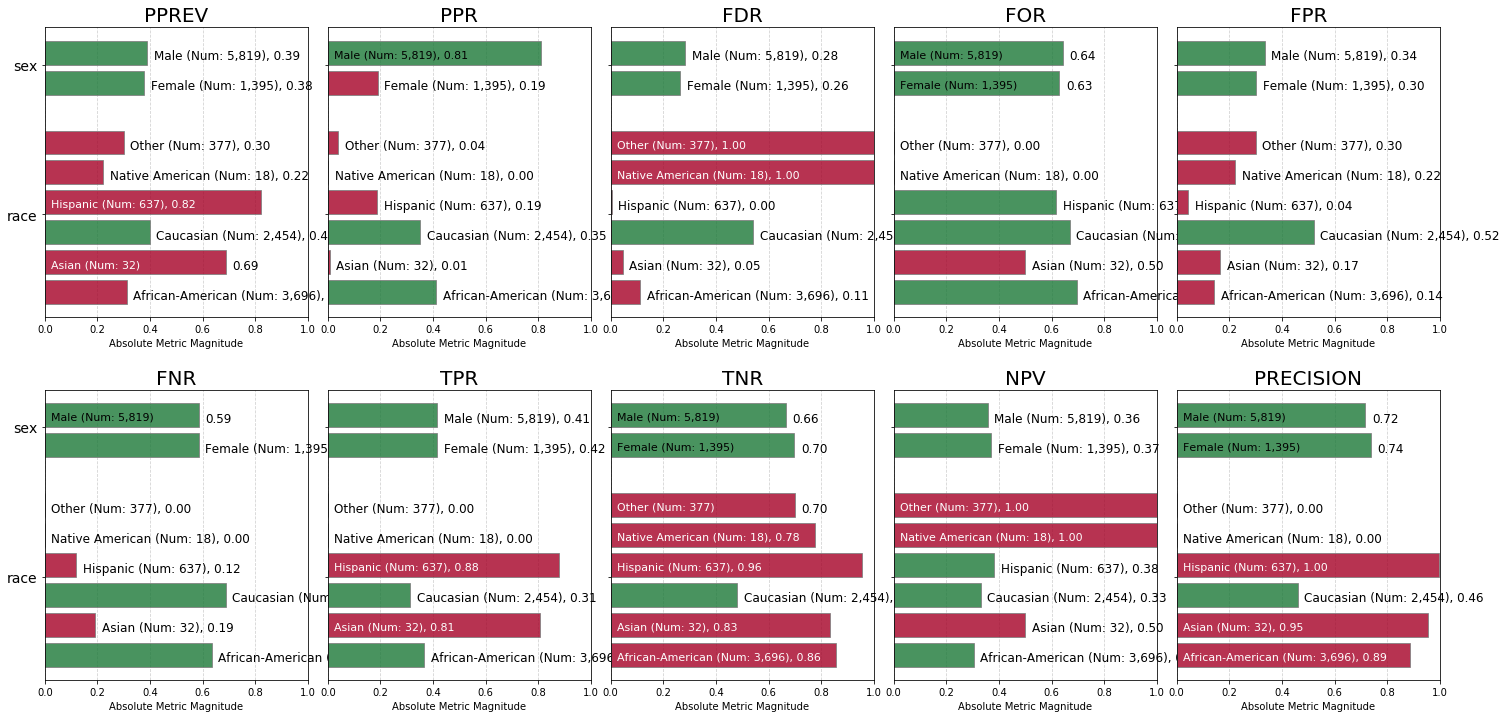

<Figure size 432x288 with 0 Axes>

In [23]:
fg = aqp.plot_fairness_group_all(fdf, ncols=5, metrics = "all")

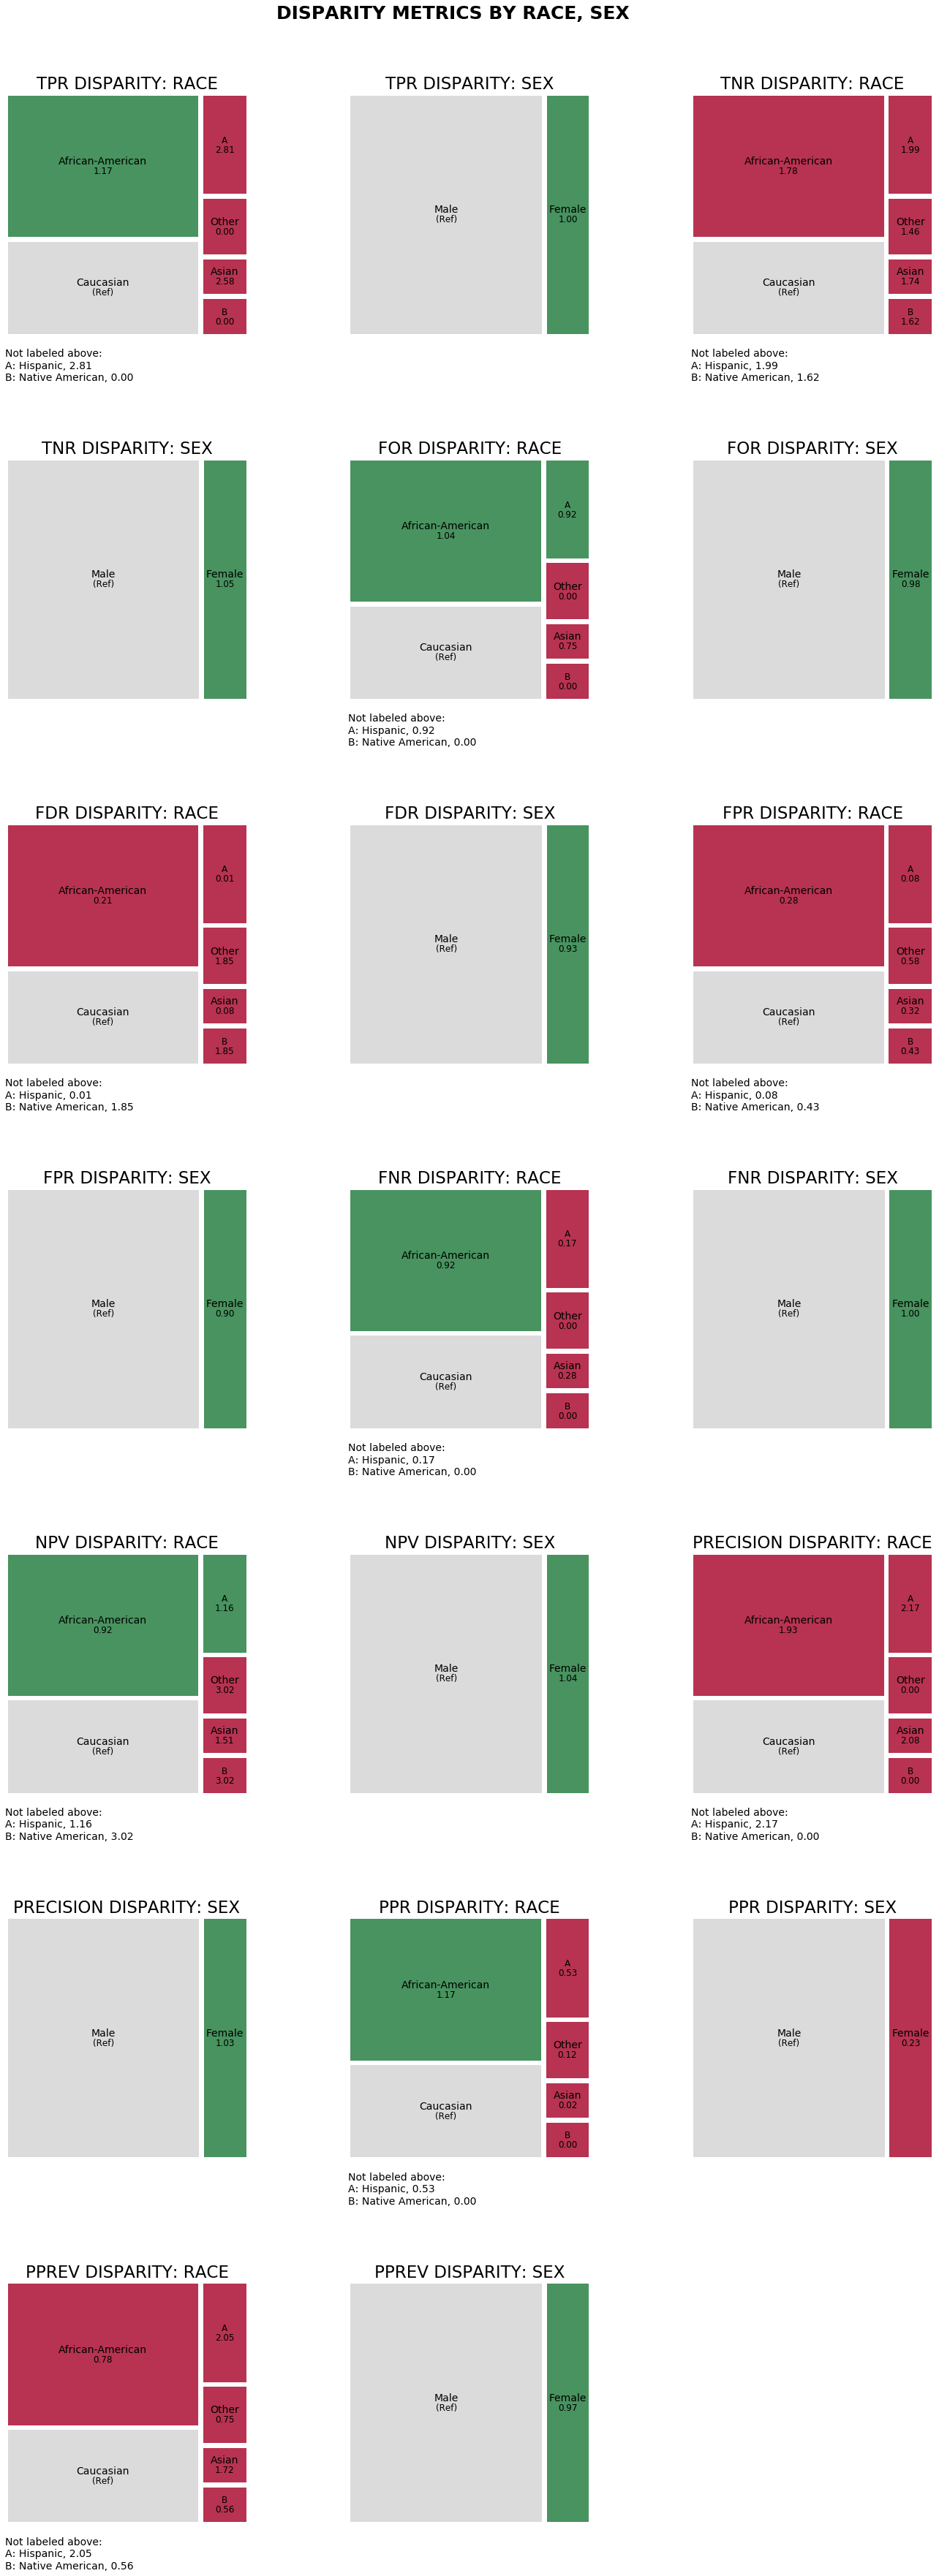

In [24]:
a_tm = aqp.plot_fairness_disparity_all(fdf, attributes=['race', 'sex'], metrics='all', 
                                       significance_alpha=0.05)